In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


Model construction

In [6]:
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout
from keras.layers.advanced_activations import LeakyReLU

C:\Users\komisare\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [7]:
def create_model(number_of_feat=1, height=100, width=100):
    model = Sequential()
    model.add(Conv2D(16, kernel_size=(3,3), input_shape=(number_of_feat * height, width, 4), padding='same')) 
    model.add(LeakyReLU(0.1))
    model.add(Conv2D(32, kernel_size=(3,3), padding='same'))  
    model.add(LeakyReLU(0.1))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Dropout(0.25))
    model.add(Conv2D(32, kernel_size=(3,3), padding='same'))  
    model.add(LeakyReLU(0.1))
    model.add(Conv2D(64, kernel_size=(3,3), padding='same')) 
    model.add(LeakyReLU(0.1))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(256))
    model.add(LeakyReLU(0.1))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    model.add(Activation("relu"))
    return model

In [11]:
sources=['bt', 'city_lights', 'esm', 'ndvi', 'population_count',\
                                                       'population_density', 'soil_sealing', 'srtm', 'vk_heatmap']
years=[k for k in range(2000, 2018)]
X = get_dependent_variable(years=years)
y = get_independent_variable(years=years)
#print(X.shape, X1.shape)
train_X = np.reshape(X, (X.shape[0], X.shape[1] * X.shape[2], X.shape[3], X.shape[4]))
train_y = y
val_X = np.reshape(X1, (X1.shape[0], X1.shape[1] * X1.shape[2], X1.shape[3], X1.shape[4]))
val_y = y1
#print(train_X.shape, train_y.shape)
#print(val_X.shape, val_y.shape)

INIT_LR = 1e-3
BATCH_SIZE = 32
EPOCHS = 2

tbCallBack = keras.callbacks.TensorBoard(log_dir='./Graph2', histogram_freq=2, write_graph=True, write_images=True,
                                        write_grads=True)
model = create_model(number_of_feat=len(sources))
model.compile(
    loss='mse',
    optimizer=keras.optimizers.adamax(lr=INIT_LR), 
    metrics=['mse']
)
model.fit(val_X, val_y, batch_size=BATCH_SIZE,
    epochs=EPOCHS, callbacks=[tbCallBack], validation_data=(train_X, train_y))
    

C:\Users\komisare\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  
C:\Users\komisare\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  app.launch_new_instance()


Train on 10 samples, validate on 18 samples
Epoch 1/2
10/10 [==============================] - 11s 1s/step - loss: 161710669824.0000 - mean_squared_error: 161710669824.0000 - val_loss: 133099945984.0000 - val_mean_squared_error: 133099945984.0000
Epoch 2/2
10/10 [==============================] - 11s 1s/step - loss: 108515147776.0000 - mean_squared_error: 108515147776.0000 - val_loss: 104705916928.0000 - val_mean_squared_error: 104705916928.0000


In [49]:
data_cleaned = data.loc[data['Population number'].str.isdigit()]
y.shape

(4542,)

In [9]:
from scipy.misc import imread, imresize

def get_dependent_variable(cities=['Tallinn'], sources=['bt', 'city_lights', 'esm',\
                                                        'ndvi', 'population_count',\
                                                       'population_density', 'soil_sealing', 'srtm', 'vk_heatmap'],
                            img_height=100, img_width=100, years=[k for k in range(2000, 2018)]):
    X = np.zeros((len(cities) * len(years), len(sources), img_height, img_width, 4))
    last_valid = None
    for i in range(len(cities)):
        city = cities[i]
        for k in range(len(years)):
            year = years[k]
            for j in range(len(sources)):
                source = sources[j]
                try:
                    file = imread("data/" + city + "/" + city + "_" + source + "_" + str(year) + ".png")
                    img_array = np.array(file)
                    img_array = imresize(img_array, (img_height, img_width))
                    X[i*len(years) + k, j, :, :, :] = img_array
                    last_valid = img_array
                except:
                    if last_valid is not None:
                        X[i*len(years) + k, j, :, :, :] = last_valid
                    else:
                        X[i*len(years) + k, j, :, :, :] = np.zeros((img_height, img_width, 4))
    #X = np.reshape(X, (X.shape[0], X.shape[1] * X.shape[2], X.shape[3], X.shape[4]))
    return X

def get_independent_variable(cities=['Tallinn'], years=[1989]):
    data = pd.read_csv("population.csv",encoding='latin1', sep="\t", header=None)
    data.columns = ["year","city/county/municipality","Population number", "Age unknown",\
                    "Population aged 0-14", "Population aged 15-64", "Population aged 65+", "Dependancy ratio"]
    y = []
    for city in cities:
        for i in range(len(data.index)):
            if city in data.loc[data.index[i], 'city/county/municipality'] and\
            int(data.loc[data.index[i], 'year']) in years:
                y.append(int(data.loc[data.index[i], "Population number"]))
    return np.array(y)
            

    
            
X = get_dependent_variable()
y = get_independent_variable(years=[i for i in range(2000, 2019)])
print(y)
#X.shape, y.shape

C:\Users\komisare\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  
C:\Users\komisare\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  app.launch_new_instance()


[402390 400090 396490 395050 398310 400500 398380 396770 396800 397400
 398500 401120 403862 406059 411063 413782 423420 426538]


In [10]:
import random
from scipy import ndarray
import skimage as sk
from skimage import transform
from skimage import util

def random_rotation(image_array: ndarray):
    random_degree = random.uniform(-25, 25)
    return sk.transform.rotate(image_array, random_degree)

def random_noise(image_array: ndarray):
    image_array += np.random.randint(-10, 10)
    image_array[image_array < 0] = 0
    image_array[image_array > 255] = 255
    return image_array

def horizontal_flip(image_array: ndarray):
    return image_array[:, ::-1]

available_transformations = {
    'rotate': random_rotation,
    'noise': random_noise,
    'horizontal_flip': horizontal_flip
}

def augement_data(X, y, n):
    y_mean = np.mean(y)
    y_std = np.std(y)
    augemented_X = np.zeros((n,X.shape[2], X.shape[3], X.shape[4], X.shape[5]))
    #np.zeros((n, X.shape[1], X.shape[2], X.shape[3], X.shape[4], X.shape[5]))
    augemented_y = np.zeros(n)
    for i in range(n):
        ii = np.random.randint(X.shape[0])
        jj = np.random.randint(X.shape[1])
        kk = np.random.randint(X.shape[2])
        
        #for j in range(X.shape[1]):
        for k in range(X.shape[2]):
            key = random.choice(list(available_transformations))
            transformed_image = available_transformations[key](X[ii, jj, kk, :, :, :])
            if ndarray.max(transformed_image) > 255 or ndarray.max(transformed_image) < 2:
                print(transformed_image)
                print(key)

            augemented_X[i, k, :, :, :] = transformed_image
        augemented_y[i] = y[ii] + np.random.randint(-1 * int(0.1 * y_std), int(0.1 * y_std))
        
    return augemented_X, augemented_y

X = get_dependent_variable()
X = np.reshape(X, (1, X.shape[0], X.shape[1], X.shape[2], X.shape[3], X.shape[4]))
X1, y1 = augement_data(X, y, 10)
print(X1.shape)
    

C:\Users\komisare\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  
C:\Users\komisare\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  app.launch_new_instance()


(10, 9, 100, 100, 4)


In [88]:
print(X.shape, X1.shape)
print(y.shape, y1.shape)
X1[0, 0, 0, :, :, :]

(1, 18, 9, 100, 100, 4) (100, 9, 100, 100, 4)
(18,) (100,)


IndexError: too many indices for array

In [11]:
import scipy.misc
scipy.misc.imsave('outfile.png', X1[0, 0, 0, :, :, :])

C:\Users\komisare\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  


In [72]:
y = data.loc[data['city/county/municipality'] == '..Tallinn', 'Population number']
y

6       478974
253     402390
500     400090
747     396490
994     395050
1241    398310
1488    400500
1735    398380
1982    396770
2229    396800
2476    397400
2723    398500
2970    401120
3217    403862
3464    406059
3711    411063
3958    413782
4205    423420
4452    426538
Name: Population number, dtype: object

In [144]:
X.tofile('pixels_data.txt', sep=',')

In [44]:
input_img = model.layers[0].input
layer_names = [layer.name for layer in model.layers if 'conv' in layer.name]
layer_dict = dict([(layer.name, layer) for layer in model.layers])

In [45]:
print(input_img, layer_names, layer_dict.items())

Tensor("conv2d_37_input:0", shape=(?, 900, 100, 4), dtype=float32) ['conv2d_37', 'conv2d_38', 'conv2d_39', 'conv2d_40'] dict_items([('conv2d_37', <keras.layers.convolutional.Conv2D object at 0x0000022EBDFD5F60>), ('leaky_re_lu_46', <keras.layers.advanced_activations.LeakyReLU object at 0x0000022EBDFD5B70>), ('conv2d_38', <keras.layers.convolutional.Conv2D object at 0x0000022EBDFD5DA0>), ('leaky_re_lu_47', <keras.layers.advanced_activations.LeakyReLU object at 0x0000022EBDFD5CC0>), ('max_pooling2d_19', <keras.layers.pooling.MaxPooling2D object at 0x0000022E8F0DDD30>), ('dropout_28', <keras.layers.core.Dropout object at 0x0000022EBAECF6D8>), ('conv2d_39', <keras.layers.convolutional.Conv2D object at 0x0000022EBAECF860>), ('leaky_re_lu_48', <keras.layers.advanced_activations.LeakyReLU object at 0x0000022EBAED8CC0>), ('conv2d_40', <keras.layers.convolutional.Conv2D object at 0x0000022EBAEED320>), ('leaky_re_lu_49', <keras.layers.advanced_activations.LeakyReLU object at 0x0000022EBAEE4DA0>)

find images that maximize feature maps
plot them...


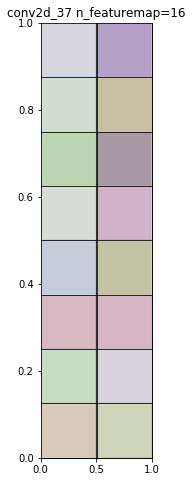

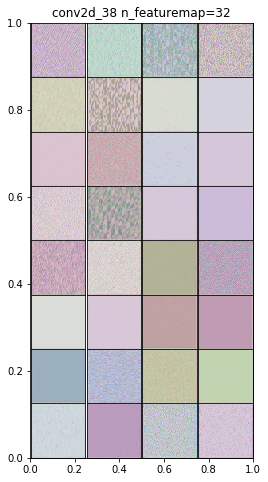

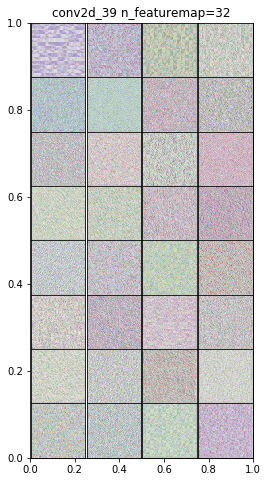

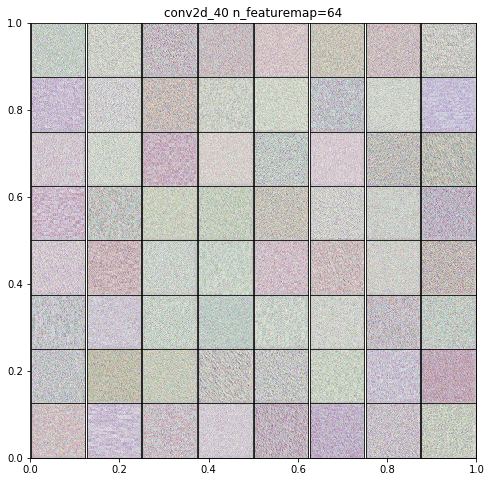

In [68]:
from keras import backend as K

class VisualizeImageMaximizeFmap(object):
    def __init__(self,pic_shape):
        '''
        pic_shape : a dimention of a single picture e.g., (96,96,1)
        '''
        self.pic_shape = pic_shape
        
    def find_n_feature_map(self,layer_name,max_nfmap):
        '''
        shows the number of feature maps for this layer
        only works if the layer is CNN
        '''
        n_fmap = None
        for layer in model.layers:
            if layer.name == layer_name:
                weights = layer.get_weights()
                n_fmap=weights[1].shape[0]
        if n_fmap is None:
            print(layer_name + " is not one of the layer names..")
            n_fmap = 1
        n_fmap = np.min([max_nfmap,n_fmap])
        return(int(n_fmap))

    def find_image_maximizing_activation(self,iterate,input_img_data,
                                         picorig=False,
                                         n_iter = 30):
        '''
        The input image is scaled to range between 0 and 1
        picorig  : True  if the picture image for input is original scale
                         ranging between 0 and 225
                   False if the picture image for input is ranging [0,1]
        '''
            
        input_img_data = np.random.random((1, 
                                           self.pic_shape[0],
                                           self.pic_shape[1],
                                           self.pic_shape[2]))
        if picorig:
            ## if the original picture is unscaled and ranging between (0,225),
            ## then the image values are centered around 123 with STD=25
            input_img_data = input_img_data*25 + 123 
        ## I played with this step value but the final image looks to be robust
        step = 500 

        
        
        # gradient ascent
        loss_values = []
        for i in range(n_iter):
            loss_value, grads_value = iterate([input_img_data, 0])
            input_img_data += grads_value * step
            loss_values.append(loss_value) 
        return(input_img_data,loss_values)

    def create_iterate(self,input_img, layer_output,filter_index):
        '''
        layer_output[:,:,:,0] is (Nsample, 94, 94) tensor contains:
        W0^T [f(image)]_{i,j}], i = 1,..., 94, j = 1,..., 94
        
        layer_output[:,:,:,1] contains:
        W1^T [f(image)]_{i,j}], i = 1,..., 94, j = 1,..., 94
        
        W0 and W1 are different kernel!
        '''
        ## loss is a scalar 
        if len(layer_output.shape) == 4:
            ## conv layer 
            loss = K.mean(layer_output[:,  :, :, filter_index])
        elif len(layer_output.shape) ==2:
            ## fully connected layer
            loss = K.mean(layer_output[:, filter_index])
         
        # calculate the gradient of the loss evaluated at the provided image
        grads = K.gradients(loss, input_img)[0]
        # normalize the gradients
        grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

        # iterate is a function taking (input_img, scalar) and output [loss_value, gradient_value]
        iterate = K.function([input_img, K.learning_phase()], [loss, grads])
        return(iterate)

    def deprocess_image(self,x):
        # standardize to have a mean 0 and std  0.1 
        x -= x.mean()
        x /= (x.std() + 1e-5)
        x *= 0.1

        # Shift x to have a mean 0.5 and std 0.1
        # This means 95% of the x should be in between 0 and 1
        # if x is normal
        x += 0.5
        x = np.clip(x, 0, 1)

        # resclar the values to range between 0 and 255
        x *= 255
        x = np.clip(x, 0, 255).astype('uint8')

        return x

    def find_images(self,input_img,layer_names,layer_dict, max_nfmap,
                    picorig=False,n_iter=30):
        '''
        Input :

        input_img   : the alias of the input layer from the deep learning model
        layer_names : list containing the name of the layers whose feature maps to be used
        layer_dict  : symbolic outputs of each "key" layer (we gave them unique names).
        max_nfmap   : the maximum number of feature map to be used for each layer.
        pic_shape   : For example pic_shape = (96,96,1)

        Output : 
        dictionary 

        key = layer name 
        value = a list containing the tuple of (images, list of loss_values) that maximize each feature map
        '''
        argimage = {}
        ## Look for the image for each feature map of each layer one by one
        for layer_name in layer_names: ## the layer to visualize
            n_fmap = self.find_n_feature_map(layer_name,max_nfmap)
            layer_output = layer_dict[layer_name].output
            result = self.find_images_for_layer(input_img,
                                                layer_output,
                                                range(n_fmap),
                                                picorig=picorig,
                                                n_iter=n_iter)

            argimage[layer_name] = result
        return(argimage)

    def find_images_for_layer(self,input_img,layer_output,indecies,
                              picorig=False,n_iter=30):
        '''
        indecies : list containing index of 
                      --> filtermaps of CNN or 
                      --> nodes of fully-connected layer
        Output

        a list containing the tuple of (images, list of loss_values) 
        that maximize each feature map


        '''
        result_temp = []
        for filter_index in indecies: # filtermap to visualize
                iterate = self.create_iterate(input_img, layer_output,filter_index)
                input_img_data, loss_values = self.find_image_maximizing_activation(
                    iterate,input_img,
                    picorig=picorig,
                    n_iter=n_iter)
                result_temp.append((input_img_data,loss_values))
        return(result_temp)

    def plot_images_wrapper(self,argimage,n_row = 8, scale = 1):
        '''
        scale : scale up or down the plot size
        '''
        pic_shape = self.pic_shape
        if pic_shape[2] == 1:
            pic_shape = self.pic_shape[:2]
        layer_names = np.sort(list(argimage.keys()))


        for layer_name in layer_names:
            n_fmap = len(argimage[layer_name])
            n_col = np.ceil(n_fmap/float(n_row))
            fig = plt.figure(figsize=(n_col*scale,
                                      n_row*scale))
            fig.subplots_adjust(hspace=0.001,wspace=0.001)
            plt.title(layer_name + " n_featuremap=" + str(n_fmap))
            count = 1
            for value in argimage[layer_name]:
                input_img_data = value[0][0]
                img = self.deprocess_image(input_img_data)
                ax = fig.add_subplot(n_row,n_col,count,
                                    xticks=[],yticks=[])
                ax.imshow(img.reshape(*pic_shape),cmap="gray")
                count += 1
            plt.show()
            
            
max_nfmap = np.Inf ## print ALL the images

visualizer = VisualizeImageMaximizeFmap(pic_shape = (96,96,4))
print("find images that maximize feature maps")
argimage = visualizer.find_images(input_img,
                                  layer_names,
                                  layer_dict, 
                                  max_nfmap)
print("plot them...")
visualizer.plot_images_wrapper(argimage,n_row = 8, scale = 1)

In [60]:
filter_index = 0  # can be any integer from 0 to 511, as there are 512 filters in that layer

# build a loss function that maximizes the activation
# of the nth filter of the layer considered
layer_name = layer_names[0]
img_width, img_height = 400, 400
layer_output = layer_dict[layer_name].output
loss = K.mean(layer_output[:, :, :, filter_index])
step = 0.1

# compute the gradient of the input picture wrt this loss
grads = K.gradients(loss, input_img)[0]

# normalization trick: we normalize the gradient
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

# this function returns the loss and grads given the input picture
iterate = K.function([input_img], [loss, grads])

# we start from a gray image with some noise
input_img_data = np.random.random((1, img_width, img_height, 4)) * 20 + 128.
# run gradient ascent for 20 steps
for i in range(20):
    loss_value, grads_value = iterate([input_img_data])
    input_img_data += grads_value * step
    
from scipy.misc import imsave

# util function to convert a tensor into a valid image
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

img = input_img_data[0]
img = deprocess_image(img)
img = np.reshape(img, (img_height, img_width, 4))
imsave('%s_filter_%d.png' % (layer_name, filter_index), img)

C:\Users\komisare\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:49: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


In [67]:
d = {k : 1 for k in ['conv2d_37', 'conv2d_38', 'conv2d_39', 'conv2d_40']}
np.sort(list(d.keys()))

array(['conv2d_37', 'conv2d_38', 'conv2d_39', 'conv2d_40'], dtype='<U9')

In [93]:
kk = np.random.randint(X.shape[2])


available_transformations = {
    'rotate': random_rotation,
    'noise': random_noise,
    'horizontal_flip': horizontal_flip
}

for k in range(10):
    ii = np.random.randint(X.shape[0])
    jj = np.random.randint(X.shape[1])
    scipy.misc.imsave('augmentation/aug_' + str(k) + '_0.png', imresize(X[ii, jj, :, :, :], (400, 400)))
    for i in range(1, 10):
        transformed_image = X[ii, jj, :, :, :]
        for j in range(3):
            key = random.choice(list(available_transformations))
            transformed_image = available_transformations[key](transformed_image)
            #print(key, i)
        scipy.misc.imsave('augmentation/aug_' + str(k) + "_" + str(i) + '.png', imresize(transformed_image, (400, 400)))
print(transformed_image.shape)
#scipy.misc.imsave('aug.png', transformed_image)

C:\Users\komisare\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  del sys.path[0]
C:\Users\komisare\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  del sys.path[0]
C:\Users\komisare\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
C:\Users\komisare\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use

(100, 100, 4)


In [20]:
from tkinter import *
import numpy as np
from tkinter import messagebox

def callback():
    messagebox.showinfo("", "Estimated population: " + str(np.random.randint(300000, 500000)))
    #l.pack()

root = Toplevel()
root.title("Population estimation tool")
root.geometry("500x500")
background_image= PhotoImage(file='spaceapps/images/tallinn_map.png')
background_label = Label(root, image=background_image)
background_label.place(x=0, y=0, relwidth=1, relheight=1)
T = Text(root, height=2, width=20)
T.pack()
T.insert(END, "Insert path to files here: data/")
b = Button(root, text="estimate", command=callback)
b.pack()
root.mainloop()

In [12]:
model.save_weights("model.hdf5")

In [31]:
import time

city = "Tallinn"
year = 2005
model = create_model(number_of_feat=len(sources))
model.load_weights("trained_models/model.hdf5")
print("Architecture used:\n")
time.sleep(1)
print(model.summary())
time.sleep(1)
print("Prediction in progress for " + city)
X = get_dependent_variable(cities=[city], sources=['bt', 'city_lights', 'esm',\
                                                        'ndvi', 'population_count',\
                                                       'population_density', 'soil_sealing', 'srtm', 'vk_heatmap'],
                            img_height=100, img_width=100, years=[year])
X = np.reshape(X, (X.shape[0], X.shape[1] * X.shape[2], X.shape[3], X.shape[4]))
print("Model prediction (population estimation) for city " + city + " is: " + str(int(model.predict(X)[0][0])) + " people")

Architecture used:

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_29 (Conv2D)           (None, 900, 100, 16)      592       
_________________________________________________________________
leaky_re_lu_36 (LeakyReLU)   (None, 900, 100, 16)      0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 900, 100, 32)      4640      
_________________________________________________________________
leaky_re_lu_37 (LeakyReLU)   (None, 900, 100, 32)      0         
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 450, 50, 32)       0         
_________________________________________________________________
dropout_22 (Dropout)         (None, 450, 50, 32)       0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 450, 50, 32)       9

C:\Users\komisare\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  
C:\Users\komisare\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  app.launch_new_instance()


Model prediction (population estimation) for city Tallinn is: 65778 people


In [37]:
import os

os.path.exists("trained_models/")

True